### **Data Preparing and Modeling Notebook**

**Overview:**
As a photography enthusiast, I am interested in building an photography genre image classification for landscape and portrait. This project's target is a bianry output. 0 being landscape and 1 being portrait.


**Business Problem:**
The photography classification can aid in organizing and categorizing artworks, creating thematic exhibitions, and conducting research on specific genres. It also helps organize and categorize independent photographers' own images, improve search and discovery, and gain insights into popular genres.
An accurate genre classification can enhance online photography platforms by improving search functionality, enabling better content recommendations, and enhancing user experience.

**Stakeholder:**
Curators and Art Galleries, online photography platform, and photographers.

**Data:**
10K images in total. 5000 Portrait images from Unsplash, 5000 landscape images combined from Kaggle dataset and Unsplash.






Import libraries

In [50]:
# Import analysis libraries
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
%matplotlib inline

#Import image data
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
#from tf.keras.preprocessing import smart_resize
#from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from PIL import Image
import random
import pickle
import cv2
import os

#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score

#KERAS
from keras import callbacks
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [4]:
# import data from google drive, mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


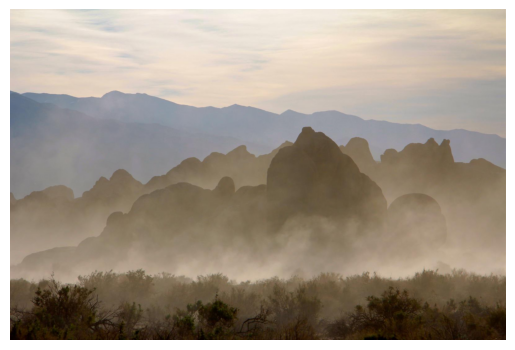

In [5]:
# check an image of landscape
image_path = '/content/drive/MyDrive/data/landscape/00000761.jpg'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()




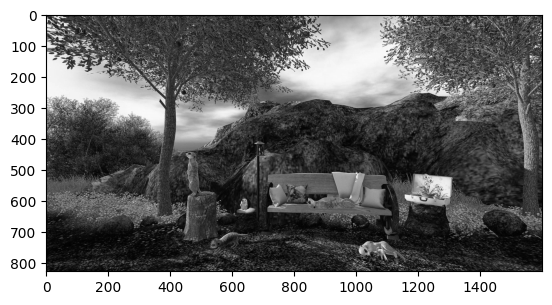

In [6]:
# Merge 2 image folders for lanscape and portrait

DATADIR = "/content/drive/MyDrive/data"
CATEGORIES = ["landscape","portrait"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap ='gray')
    plt.show()
    break
  break


In [7]:
print(img_array)

[[ 54  41  45 ... 101  54  20]
 [  6   0   9 ...  80  15  45]
 [ 97 103 134 ...  14  79 111]
 ...
 [ 20  15   9 ...  33  48  62]
 [ 14   4   1 ...  64  61  50]
 [  2   5  19 ...  68  77  73]]


In [8]:
img_array.shape

(826, 1600)

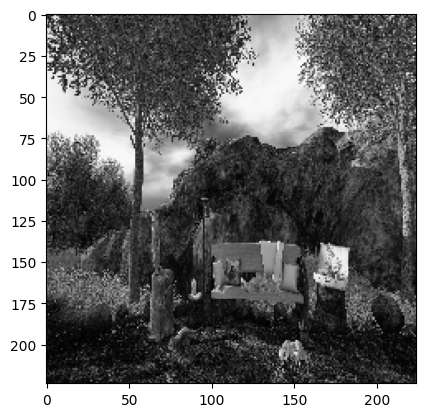

In [9]:
# change size of the image and see how it looks, revise img_size...
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [10]:
# create a entire data set with all ~5030 landscape and ~5030 portraits and reshape them to 224 x 224, grayscaled or colored?
dataset = []

def create_dataset():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category) # labels the data to 0 and 1, 0 for landscape, 1 for portrait
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # change to all grey scale
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resize
        dataset.append([new_array, class_num])
      except Exception as e:
        pass

create_dataset()

In [11]:
print(len(dataset))

10060


In [12]:
# shuttle or randomize enire dataset
import random
random.shuffle(dataset)

In [13]:
for sample in dataset[:10]:
  print(sample[1])

1
0
1
0
0
0
1
1
0
1


In [14]:
# Define features and target
X = []
y = []

In [15]:
# Split dataset to X and y
for features, label in dataset:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,1) #1 is for gray scale, 3 is for colored

In [16]:
# create separate files for features and targets

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()


In [17]:
X = pickle.load(open("X.pickle", 'rb'))
y = pickle.load(open("y.pickle", 'rb'))

In [18]:
# Normalize X of the entire dataset
X = X/255.0

In [19]:
X.shape

(10060, 224, 224, 1)

In [20]:
len(y)

10060

In [21]:
y = np.array(y)

In [22]:
# Get the unique values and their counts
unique_values, value_counts = np.unique(y, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count}")

0: 5027
1: 5033




Split the dataset to training, validation and testing

In [23]:
# 0.15 for testing, 0.15 for validation, and 0.7 for training

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.176, random_state = 42)

# **Start Modeling:**
First, we want to come up with a dummy model. I will use a very simple convolutional neural net for this.

In [25]:
# Create a Sequential model
dummy_model = Sequential()

# Add convolutional layers
dummy_model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224, 1)))
dummy_model.add(MaxPooling2D((2, 2)))
dummy_model.add(Conv2D(32, (3, 3), activation='relu'))
dummy_model.add(MaxPooling2D((2, 2)))
dummy_model.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten the output from the previous layer
dummy_model.add(Flatten())

# Add a dense (fully connected) layer
dummy_model.add(Dense(64, activation='relu'))

# Add the output layer
dummy_model.add(Dense(1, activation='sigmoid'))

# Compile the model
dummy_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


dummy_results = dummy_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
221/221 [==============================] - 9s 30ms/step - loss: 0.2449 - accuracy: 0.9089 - val_loss: 0.1587 - val_accuracy: 0.9495
Epoch 2/10
221/221 [==============================] - 5s 25ms/step - loss: 0.0924 - accuracy: 0.9709 - val_loss: 0.0853 - val_accuracy: 0.9721
Epoch 3/10
221/221 [==============================] - 6s 25ms/step - loss: 0.0760 - accuracy: 0.9715 - val_loss: 0.1286 - val_accuracy: 0.9628
Epoch 4/10
221/221 [==============================] - 6s 26ms/step - loss: 0.0364 - accuracy: 0.9884 - val_loss: 0.1094 - val_accuracy: 0.9694
Epoch 5/10
221/221 [==============================] - 6s 25ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.1129 - val_accuracy: 0.9708
Epoch 6/10
221/221 [==============================] - 5s 25ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.1138 - val_accuracy: 0.9728
Epoch 7/10
221/221 [==============================] - 6s 26ms/step - loss: 0.0072 - accuracy: 0.9974 - val_loss: 0.1422 - val_accuracy: 0.9721

Visualizations for loss and accuracy comparing training and testing

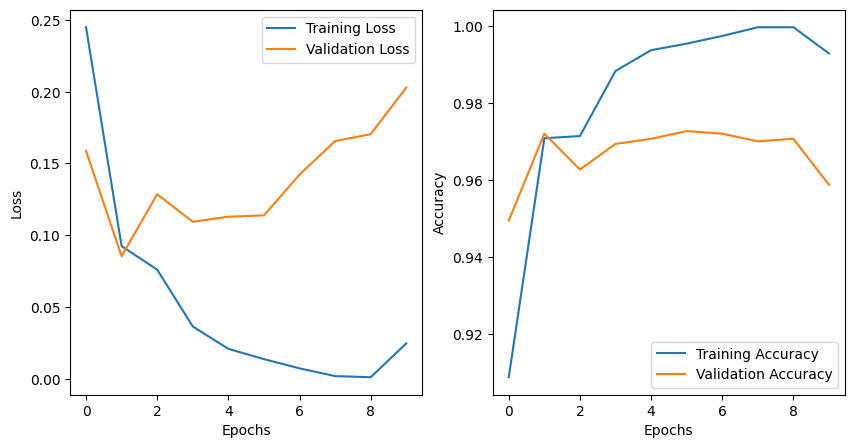

In [26]:
train_loss = dummy_results.history['loss']
train_accuracy = dummy_results.history['accuracy']

val_loss = dummy_results.history['val_loss']
val_accuracy = dummy_results.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=dummy_results.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=dummy_results.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=dummy_results.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=dummy_results.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()



In [27]:
val_loss, val_acc = dummy_model.evaluate(X_val, y_val)

48/48 [==============================] - 0s 9ms/step - loss: 0.2029 - accuracy: 0.9588


The dummy model is extremely overfit comparing its loss and accuracy between training and validation results.

Ways to improve:
1. Use Augmentation to increase the diversity of the training data.
2. Add regularizations (L1 and L2) and dropout
3. Reduce image size
4. Add early stopping
5. Model complexity reduction: decreasing the number of layers, reducing the number of filters, or using smaller filter sizes.

### Add Augmentation




In [ ]:
# add early stop
# early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=1, mode='min', patience=5) # focus on val_loss

In [28]:
# define augmentation parameters
aug1 = ImageDataGenerator(
    rotation_range=20, # rotate images randomly up to 20 degrees
    width_shift_range=0.2, #shift image horizontally by a fraction of the total width
    height_shift_range=0.2, #shift image vertically by a fraction of the total height
    brightness_range=None,
    shear_range=0.2, # apply shear transformation
    zoom_range=0.2, # zoom in / out on image
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip= True,
    vertical_flip= True
)

# Apply augmentation on training data
train_generator1 = aug1.flow(X_train, y_train, batch_size = 32)

# Use fit_generator to fit the training data with augmentation
results2 = dummy_model.fit_generator(train_generator1,
          epochs = 30,
          validation_data = (X_val, y_val))
          # callbacks = [early_stop])

Epoch 1/30


<ipython-input-28-3e6cecef2271>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results2 = dummy_model.fit_generator(train_generator1,


221/221 [==============================] - 25s 110ms/step - loss: 0.2726 - accuracy: 0.9009 - val_loss: 0.1377 - val_accuracy: 0.9581
Epoch 2/30
221/221 [==============================] - 23s 105ms/step - loss: 0.1521 - accuracy: 0.9466 - val_loss: 0.1233 - val_accuracy: 0.9641
Epoch 3/30
221/221 [==============================] - 24s 107ms/step - loss: 0.1411 - accuracy: 0.9503 - val_loss: 0.1386 - val_accuracy: 0.9508
Epoch 4/30
221/221 [==============================] - 24s 107ms/step - loss: 0.1326 - accuracy: 0.9564 - val_loss: 0.2083 - val_accuracy: 0.9342
Epoch 5/30
221/221 [==============================] - 23s 106ms/step - loss: 0.1232 - accuracy: 0.9581 - val_loss: 0.1531 - val_accuracy: 0.9488
Epoch 6/30
221/221 [==============================] - 23s 105ms/step - loss: 0.1127 - accuracy: 0.9576 - val_loss: 0.1007 - val_accuracy: 0.9628
Epoch 7/30
221/221 [==============================] - 23s 106ms/step - loss: 0.1054 - accuracy: 0.9635 - val_loss: 0.1001 - val_accuracy: 0.9

# VISUALIZATION for 30 epochs with augmentation:

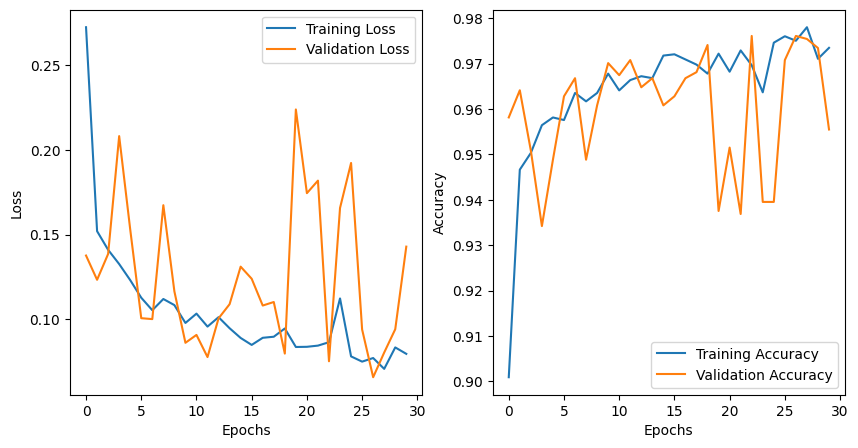

In [29]:
train_loss = results2.history['loss']
train_accuracy = results2.history['accuracy']

val_loss = results2.history['val_loss']
val_accuracy = results2.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results2.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results2.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results2.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results2.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

Do a predict on an image.

In [30]:
# Save the augmentation configuration
with open("augmentation_config1.pkl", "wb") as file:
    pickle.dump(aug1, file)

In [31]:
# Load the augmentation configuration
with open("augmentation_config1.pkl", "rb") as file:
    aug = pickle.load(file)

In [32]:
y_pred_prob = dummy_model.predict(X_val)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)
print(y_pred)

48/48 [==============================] - 0s 7ms/step
[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [0]]


In [33]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       756
           1       1.00      0.91      0.95       749

    accuracy                           0.96      1505
   macro avg       0.96      0.96      0.96      1505
weighted avg       0.96      0.96      0.96      1505



In [34]:
val_loss, val_acc = dummy_model.evaluate(X_val, y_val)

48/48 [==============================] - 0s 8ms/step - loss: 0.1429 - accuracy: 0.9555






without augmentation:
loss: 0.0246 - accuracy: 0.9929 - val_loss: 0.2029 - val_accuracy: 0.9588

with augmentation:
loss: 0.0796 - accuracy: 0.9735 - val_loss: 0.1429 - val_accuracy: 0.9555

Compared to the dummy model with no augmentation, with augmentation, validation loss has improved by 0.06.




To further improve the model, we can try to tweak the numbers of layers (both convolutional layer and dense layer), also change the number of nodes per layer.

### Model 2: 3 convolutional layers and 0 dense layer.

In [36]:
# 3 convolutional layers, 0 dense layer
# Create the convolutional base
model2 = Sequential()
model2.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224,224, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu')) # add one more convolutional layer
model2.add(MaxPooling2D(pool_size=(2, 2)))


# Add Dense layers on top
model2.add(Flatten())
#model2.add(Dense(64, activation='relu')) #remove dense layer

# Add output layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# fit the model with augmentation and early stop
results3 = model2.fit_generator(train_generator1,
          epochs = 30,
          validation_data = (X_val, y_val))
          #callbacks = [early_stop])

Epoch 1/30


<ipython-input-36-b1c5d1c6e6f9>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results3 = model2.fit_generator(train_generator1,


221/221 [==============================] - 27s 110ms/step - loss: 0.3938 - accuracy: 0.8100 - val_loss: 0.1814 - val_accuracy: 0.9508
Epoch 2/30
221/221 [==============================] - 24s 108ms/step - loss: 0.2171 - accuracy: 0.9297 - val_loss: 0.1545 - val_accuracy: 0.9595
Epoch 3/30
221/221 [==============================] - 24s 109ms/step - loss: 0.1870 - accuracy: 0.9398 - val_loss: 0.1149 - val_accuracy: 0.9681
Epoch 4/30
221/221 [==============================] - 23s 105ms/step - loss: 0.1755 - accuracy: 0.9420 - val_loss: 0.2315 - val_accuracy: 0.9276
Epoch 5/30
221/221 [==============================] - 23s 105ms/step - loss: 0.1662 - accuracy: 0.9468 - val_loss: 0.2197 - val_accuracy: 0.9223
Epoch 6/30
221/221 [==============================] - 23s 106ms/step - loss: 0.1801 - accuracy: 0.9414 - val_loss: 0.1031 - val_accuracy: 0.9708
Epoch 7/30
221/221 [==============================] - 23s 106ms/step - loss: 0.1725 - accuracy: 0.9414 - val_loss: 0.1715 - val_accuracy: 0.9

In [37]:
val_loss, val_acc = model2.evaluate(X_val, y_val)

48/48 [==============================] - 1s 16ms/step - loss: 0.0583 - accuracy: 0.9847


Visualization of loss and accuracy

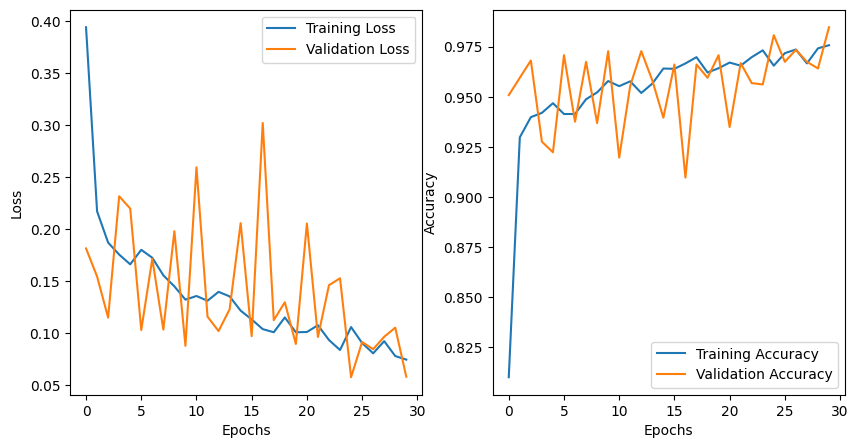

In [38]:
train_loss = results3.history['loss']
train_accuracy = results3.history['accuracy']

val_loss = results3.history['val_loss']
val_accuracy = results3.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results3.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results3.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results3.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results3.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

Model 2 improves a lot **with 3 convolutional layers and 0 dense layer while keeping the the augmentation** constant.
Comparing this model with dummy model with augmentation:

loss: 0.0796 - accuracy: 0.9735 - val_loss: 0.1429 - val_accuracy: 0.9555

new model:
loss: 0.0747 - accuracy: 0.9757 - val_loss: 0.0583 - val_accuracy: 0.9847

Both val loss and accuracy have improved greatly. also reduced overfitting!

## We can further look into classification report to evaluate the model:

In [39]:
# make prediction on X_val
y_pred_prob = model2.predict(X_val)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)


print (classification_report(y_val, y_pred))

48/48 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       756
           1       0.99      0.97      0.98       749

    accuracy                           0.98      1505
   macro avg       0.98      0.98      0.98      1505
weighted avg       0.98      0.98      0.98      1505



In [44]:
# check ROC curve and AOC score
roc_auc_score(y_val, y_pred)


0.9846709192503585

**Conclusion: Looking at the classification report and auc score of the current model with 3 convolutional layers, no dense layer, with augmentation, 30 epochs, the model performs the best so far.**

# **Final Evaluation on Unseen data/ testing data**

**We can now combine the training and validation sets as the traning set to rerun this model and use the testing data to see how this model performs on unseen data!**

If the model is ovefit, then apply regularization, and dropout.

In [46]:
# Apply same augmentation on training and validation data
train_generator2 = aug1.flow(X_train_val, y_train_val, batch_size = 64) # update batch size to 64


# fit the model with augmentation and early stop
results4 = model2.fit_generator(train_generator2,
          epochs = 30,
          validation_data = (X_test, y_test))
          #callbacks = [early_stop])

<ipython-input-46-3c4d5f318c5b>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results4 = model2.fit_generator(train_generator2,


Epoch 1/30
134/134 [==============================] - 33s 224ms/step - loss: 0.0695 - accuracy: 0.9772 - val_loss: 0.1203 - val_accuracy: 0.9675
Epoch 2/30
134/134 [==============================] - 28s 209ms/step - loss: 0.0701 - accuracy: 0.9792 - val_loss: 0.1147 - val_accuracy: 0.9655
Epoch 3/30
134/134 [==============================] - 28s 208ms/step - loss: 0.0700 - accuracy: 0.9764 - val_loss: 0.0683 - val_accuracy: 0.9861
Epoch 4/30
134/134 [==============================] - 28s 207ms/step - loss: 0.0642 - accuracy: 0.9791 - val_loss: 0.1851 - val_accuracy: 0.9543
Epoch 5/30
134/134 [==============================] - 28s 207ms/step - loss: 0.0673 - accuracy: 0.9780 - val_loss: 0.1090 - val_accuracy: 0.9735
Epoch 6/30
134/134 [==============================] - 28s 209ms/step - loss: 0.0711 - accuracy: 0.9765 - val_loss: 0.1844 - val_accuracy: 0.9417
Epoch 7/30
134/134 [==============================] - 28s 209ms/step - loss: 0.0735 - accuracy: 0.9757 - val_loss: 0.1595 - val_ac

Visualization of loss and accuracy

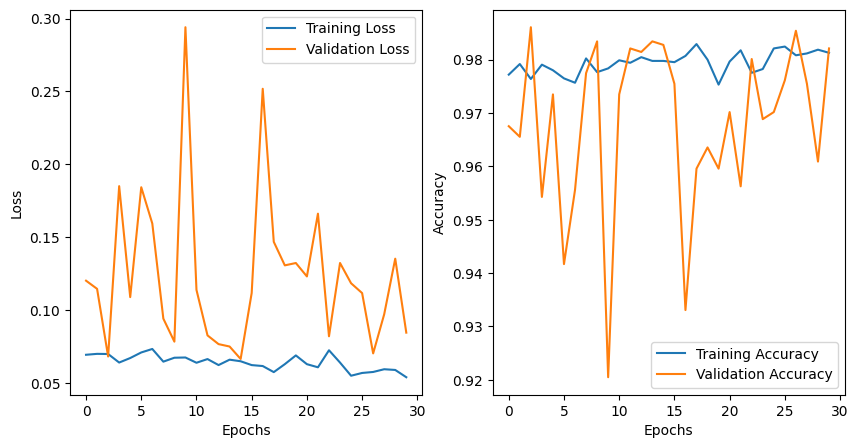

In [47]:
train_loss = results4.history['loss']
train_accuracy = results4.history['accuracy']

val_loss = results4.history['val_loss']
val_accuracy = results4.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results4.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results4.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results4.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results4.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

In [48]:
# make prediction on X_test
y_pred_prob = model2.predict(X_test)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)


print (classification_report(y_test, y_pred))

48/48 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       765
           1       1.00      0.97      0.98       744

    accuracy                           0.98      1509
   macro avg       0.98      0.98      0.98      1509
weighted avg       0.98      0.98      0.98      1509



In [49]:
# check ROC curve and AOC score
roc_auc_score(y_test, y_pred)

0.9818917351886991

**Looking at the results on the testing set, I think overall the model performs very well but I can apply regularization to see if the model can stabilize val loss/accuracy**

In [54]:
# 3 convolutional layers, 0 dense layer, L2 regularization
# Create the convolutional base
model3 = Sequential()

model3.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224,224, 1),
                        kernel_regularizer = l2(0.01))) # add L2 regularization on the first convolutional layer
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))


# Add Dense layers on top
model3.add(Flatten())
#model2.add(Dense(64, activation='relu')) #remove dense layer

# Add output layer
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# add an early stopping
#early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=1, mode='min', patience=5) # focus on val_loss

# fit the model with augmentation and early stop
results5 = model3.fit_generator(train_generator2,
          epochs = 30,
          validation_data = (X_test, y_test))
          #callbacks = [early_stop])

<ipython-input-54-aae24e21e10e>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results5 = model3.fit_generator(train_generator2,


Epoch 1/30
134/134 [==============================] - 31s 216ms/step - loss: 0.4004 - accuracy: 0.8095 - val_loss: 0.3144 - val_accuracy: 0.9092
Epoch 2/30
134/134 [==============================] - 28s 209ms/step - loss: 0.2239 - accuracy: 0.9322 - val_loss: 0.0957 - val_accuracy: 0.9781
Epoch 3/30
134/134 [==============================] - 28s 209ms/step - loss: 0.2111 - accuracy: 0.9352 - val_loss: 0.1149 - val_accuracy: 0.9728
Epoch 4/30
134/134 [==============================] - 28s 208ms/step - loss: 0.1917 - accuracy: 0.9415 - val_loss: 0.1665 - val_accuracy: 0.9596
Epoch 5/30
134/134 [==============================] - 28s 212ms/step - loss: 0.1906 - accuracy: 0.9415 - val_loss: 0.1336 - val_accuracy: 0.9636
Epoch 6/30
134/134 [==============================] - 29s 213ms/step - loss: 0.1949 - accuracy: 0.9406 - val_loss: 0.0945 - val_accuracy: 0.9788
Epoch 7/30
134/134 [==============================] - 30s 221ms/step - loss: 0.1743 - accuracy: 0.9437 - val_loss: 0.3105 - val_ac

Plot it out:

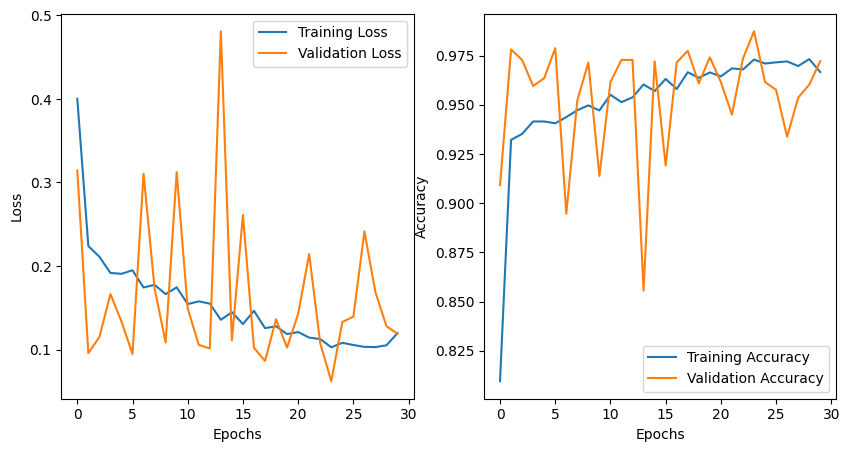

In [55]:
train_loss = results5.history['loss']
train_accuracy = results5.history['accuracy']

val_loss = results5.history['val_loss']
val_accuracy = results5.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results5.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results5.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results5.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results5.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

In [56]:
# make prediction on X_test
y_pred_prob = model3.predict(X_test)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)


print (classification_report(y_test, y_pred))

48/48 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       765
           1       1.00      0.95      0.97       744

    accuracy                           0.97      1509
   macro avg       0.97      0.97      0.97      1509
weighted avg       0.97      0.97      0.97      1509



In [57]:
# check ROC curve and AOC score
roc_auc_score(y_test, y_pred)

0.9718295382669198

Conclusion:
Comparing results with last model without regularization, this model with
regularization doesn't really improve overall model performance.

Now, we can give dropout a try.

In [58]:
model4 = Sequential()
model4.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224,224, 1)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25)) # add 1 drop out layer, drop out 0.25 of the neurons on the first convolutional layer

model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(64, (3, 3), activation='relu')) # add one more convolutional layer
model4.add(MaxPooling2D(pool_size=(2, 2)))


# Add Dense layers on top
model4.add(Flatten())
#model2.add(Dense(64, activation='relu')) #remove dense layer

# Add output layer
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Fit the model to training and validation data
model4.fit_generator(train_generator2,
          epochs = 30,
          validation_data = (X_test, y_test))

<ipython-input-58-aa94bce2b1ee>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4.fit_generator(train_generator2,


Epoch 1/30
134/134 [==============================] - 39s 277ms/step - loss: 0.4257 - accuracy: 0.7839 - val_loss: 0.1431 - val_accuracy: 0.9549
Epoch 2/30
134/134 [==============================] - 37s 273ms/step - loss: 0.1947 - accuracy: 0.9349 - val_loss: 0.1281 - val_accuracy: 0.9649
Epoch 3/30
134/134 [==============================] - 37s 272ms/step - loss: 0.1708 - accuracy: 0.9463 - val_loss: 0.1152 - val_accuracy: 0.9649
Epoch 4/30
134/134 [==============================] - 36s 271ms/step - loss: 0.1870 - accuracy: 0.9385 - val_loss: 0.3811 - val_accuracy: 0.8834
Epoch 5/30
134/134 [==============================] - 36s 269ms/step - loss: 0.1584 - accuracy: 0.9501 - val_loss: 0.1690 - val_accuracy: 0.9549
Epoch 6/30
134/134 [==============================] - 36s 264ms/step - loss: 0.1791 - accuracy: 0.9421 - val_loss: 0.2113 - val_accuracy: 0.9457
Epoch 7/30
134/134 [==============================] - 36s 265ms/step - loss: 0.1716 - accuracy: 0.9439 - val_loss: 0.2775 - val_ac

In [59]:
# make prediction on X_test
y_pred_prob = model4.predict(X_test)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)


print (classification_report(y_test, y_pred))

48/48 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       765
           1       1.00      0.88      0.94       744

    accuracy                           0.94      1509
   macro avg       0.95      0.94      0.94      1509
weighted avg       0.95      0.94      0.94      1509



**Conclusion: With 1 dropout layer, the result isn't improved compared to model 2 with no regularization nor dropout layer.**